In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from astropy.io import fits,ascii
import pandas as pd
import cmasher as cmr

In [9]:
sample = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample.csv")
# sample = sample[sample["v_asym_g"]/sample["v_asym_g_err"]>3]
# sample = sample[sample["v_asym_s"]/sample["v_asym_s_err"]>3]
prospect = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
ssp = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
bpt = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv")
prospect= prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
bpt= bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
ssp= ssp[ssp["MAGPIID"].isin(sample["MAGPIID"])]

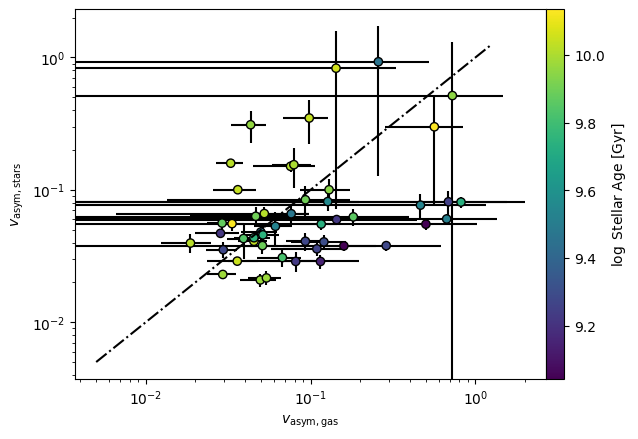

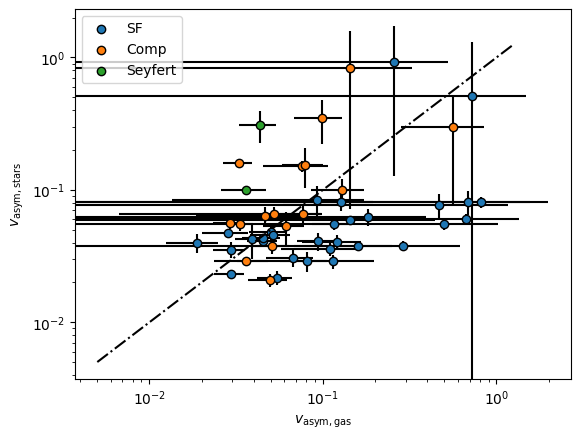

In [10]:
vg = sample["v_asym_g"].to_numpy()
vg_err = sample['v_asym_g_err'].to_numpy()
vs = sample["v_asym_s"].to_numpy()
vs_err = sample["v_asym_s_err"].to_numpy()

fig,ax = plt.subplots()
p=ax.scatter(vs,vg,ec="k",c=ssp["logage_MW_2re"].to_numpy(),zorder=2)
ax.errorbar(vs,vg,xerr=vs_err,yerr=vg_err,fmt=".k",zorder=1)
ax.plot(np.logspace(-2.3,0.1),np.logspace(-2.3,0.1),ls='dashdot',color="k")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$v_{\rm asym,gas}$")
ax.set_ylabel(r"$v_{\rm asym,stars}$")
plt.colorbar(p,ax=ax,label=r"$\log$ Stellar Age [Gyr]",pad=0,fraction=0.05)
plt.show()

fig,ax = plt.subplots()
for i,lab in zip([1,0,2],["SF","Comp","Seyfert"]):
    ax.scatter(vs[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],vg[bpt["type(sf+AGN=0, sf=1, sy=2, ln=3)"]==i],
               ec="k",zorder=2,label=lab)
    ax.errorbar(vs[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],vg[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],
                xerr=vs_err[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],
                yerr=vg_err[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],fmt=".k",zorder=1)
ax.plot(np.logspace(-2.3,0.1),np.logspace(-2.3,0.1),ls='dashdot',color="k")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$v_{\rm asym,gas}$")
ax.set_ylabel(r"$v_{\rm asym,stars}$")
ax.legend()
plt.show()

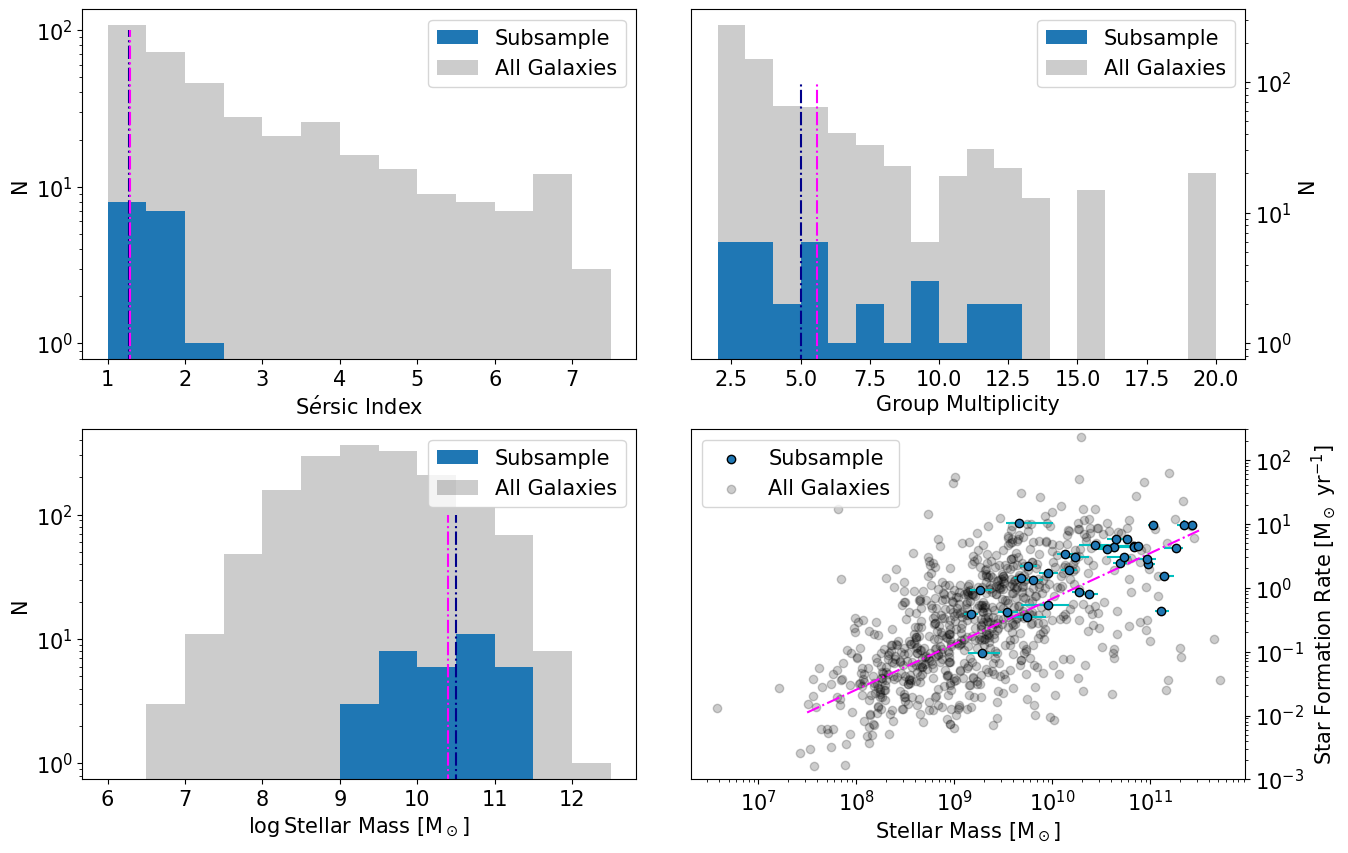

In [63]:
sample = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/kinemetry_sample_M2.csv")
#sample = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample.csv")
#sample = sample.dropna()
#sample = sample[sample["v_asym_s"]/sample["v_asym_s_err"]>3]
sample = sample[sample["v_asym_15re"]<0.1]
prospect = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")

# SFMS & Mass
t = ascii.read("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_Balmer_SFRs_onedspec.tbl")
df=pd.DataFrame({"MAGPIID":np.array(t['MAGPI_ID']),
                "SFR":np.array(t["SFR"]),
                "SFR_err":np.array(t["SFR_err"])})
df1 = df[df["MAGPIID"].isin(sample["MAGPIID"])]
df2 = df[~df["MAGPIID"].isin(sample["MAGPIID"])]
SFR = df1["SFR"].to_numpy()
SFR_err = df1["SFR_err"].to_numpy()
SFR_2 = df2["SFR"].to_numpy()
M_sol = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]["StellarMass_median"].to_numpy()
M_sol_err_16 = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]["StellarMass_16"].to_numpy()
M_sol_err_84 = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]["StellarMass_84"].to_numpy()
M_sol_err_84 = M_sol_err_84 - M_sol
M_sol_err_16 = M_sol - M_sol_err_16
M_sol_2 = prospect[prospect["MAGPIID"].isin(df2["MAGPIID"])]["StellarMass_median"].to_numpy()
xx = np.logspace(7.5,11.5, 55)
MS = (xx**0.712)*(10**-7.293)

# Environment
env = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/kinemetry_sample_env.csv")
N_Gals = env[env["MAGPIID"].isin(sample["MAGPIID"])]["N_Gals"]
not_N_gals = env[~env["MAGPIID"].isin(sample["MAGPIID"])]["N_Gals"]

# Sersic
file1 = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/kinemetry_sample_M2.csv")
file1 = file1.dropna()
file1 = file1.drop_duplicates(["MAGPIID"])
galfit = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_GalfitSersicCat_v0.0.csv")
prospect = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
n2 = galfit["n"]
n2 = n2[n2 > 0]
prospect = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
sample = sample[sample["MAGPIID"].isin(prospect["MAGPIID"])]
galfit = galfit[galfit["MAGPIID"].isin(prospect["MAGPIID"])]
n = galfit["n"]
n = n[n > 0]
re = galfit["re"].to_numpy()


plt.rcParams.update({"font.size":15})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
# Sersic
ax1.hist(n, zorder=2, label="Subsample", bins=np.arange(1,8,0.5))
ax1.hist(n2, label="All Galaxies", color="k", bins=np.arange(1,8,0.5), alpha=0.2)
ax1.vlines(np.median(n), ymin=0, ymax=100,ls="dashdot",color="darkblue")
ax1.vlines(np.mean(n), ymin=0, ymax=100,ls="dashdot",color="fuchsia")
#ax.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylabel("N")
ax1.set_xlabel(r"S$\'{e}$rsic Index")
ax1.legend()
# Environment
ax2.hist(N_Gals, label="Subsample", zorder=2,bins=np.arange(1,21,1))
#ax2.hist(N_Gals_0, zorder=2, label="No Env. Metrics")
ax2.hist(not_N_gals, label="All Galaxies", color="k", alpha=0.2, zorder=1,bins=np.arange(1,21,1))
ax2.set_yscale("log")
ax2.set_xlabel("Group Multiplicity")
ax2.vlines(np.median(N_Gals), ymin=0, ymax=100,ls="dashdot",color="darkblue")
ax2.vlines(np.mean(N_Gals), ymin=0, ymax=100,ls="dashdot",color="fuchsia")
ax2.legend()
ax2.set_ylabel("N")
ax2.set_xlim(1.05,21.05)
# Mass
ax3.hist(np.log10(M_sol), zorder=2, label="Subsample", bins=np.arange(6,13,0.5))
ax3.hist(np.log10(M_sol_2), label="All Galaxies", color="k", bins=np.arange(6,13,0.5), alpha=0.2)
ax3.vlines(np.median(np.log10(M_sol)), ymin=0, ymax=100,ls="dashdot",color="darkblue")
ax3.vlines(np.mean(np.log10(M_sol)), ymin=0, ymax=100,ls="dashdot",color="fuchsia")
#ax.set_xscale("log")
ax3.set_yscale("log")
ax3.set_ylabel("N")
ax3.set_xlabel(r"$\log$Stellar Mass [M$_\odot$]")
ax3.legend()
# SFMS
ax4.scatter(M_sol, SFR, zorder=3, label="Subsample", ec="k")
ax4.errorbar(M_sol, SFR, xerr=[M_sol_err_16,M_sol_err_84], yerr=SFR_err, zorder=2, fmt=".c", ls="")
ax4.scatter(M_sol_2, SFR_2, zorder=1, alpha=0.2, c="k", label="All Galaxies")
ax4.plot(xx, MS, ls="dashdot", c="magenta")
ax4.set_xscale("log")
ax4.set_yscale("log")
ax4.set_ylim(1e-3, 300)
ax4.set_xlabel(r"Stellar Mass [M$_\odot$]")
ax4.set_ylabel(r"Star Formation Rate [M$_\odot$ yr$^{-1}$]")
ax4.legend()
for ax in [ax2, ax4]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper1/"
            "SFMS_Mass_Sersic_Env.pdf", bbox_inches="tight")

In [13]:
sample = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_1Re.csv")
sample = sample[sample["v_asym_g_err"]<0.1]
prospect = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
ssp = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
bpt = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv")
bpt = bpt[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==1]
sample = sample[sample["MAGPIID"].isin(bpt["MAGPIID"])]
bpt= bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
prospect= prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
ssp= ssp[ssp["MAGPIID"].isin(sample["MAGPIID"])]

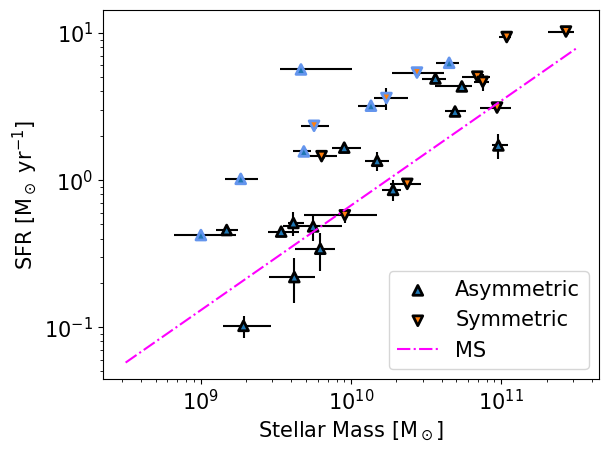

In [14]:
mass = prospect["StellarMass_median"].to_numpy()
mass_16_err = mass - prospect["StellarMass_16"].to_numpy()
mass_84_err = prospect["StellarMass_84"].to_numpy() - mass
SFR = bpt["SFR, dust corrected"].to_numpy()
SFR_err = bpt["SFR_err"].to_numpy()
asym = sample["v_asym_g"].to_numpy()
asym_err = sample["v_asym_g_err"].to_numpy()
x = np.logspace(8.5,11.5,len(SFR))
MS = (x**(0.712)*(10**(-7.293)))
colors = []
DMS = []
for i,j in zip(mass,SFR):
    DMS.append(np.log10(j) - np.log10(i**(0.712)*(10**(-7.293))))
    if (np.log10(j) - np.log10(i**(0.712)*(10**(-7.293))))>0.5:
        colors.append("cornflowerblue")
    if 0.5>(np.log10(j) - np.log10(i**(0.712)*(10**(-7.293))))>-1:
        colors.append("k")
    if (np.log10(j) - np.log10(i**(0.712)*(10**(-7.293))))<-1:
        colors.append("maroon")
colors = np.array(colors)
plt.rcParams.update({"font.size":15})
fig,ax = plt.subplots()
ax.scatter(mass[asym>0.04],SFR[asym>0.04],ec=colors[asym>0.04],marker="^",label="Asymmetric",s=50,lw=2,zorder=2)
ax.errorbar(mass[asym>0.04],SFR[asym>0.04],xerr=[mass_16_err[asym>0.04],mass_84_err[asym>0.04]],
            yerr=SFR_err[asym>0.04],fmt='.k',zorder=1)
ax.scatter(mass[asym<0.04],SFR[asym<0.04],ec=colors[asym<0.04],marker="v",label="Symmetric",s=50,lw=2,zorder=2)
ax.errorbar(mass[asym<0.04],SFR[asym<0.04],xerr=[mass_16_err[asym<0.04],mass_84_err[asym<0.04]],
            yerr=SFR_err[asym<0.04],fmt='.k',zorder=1)
ax.plot(x,MS,ls="dashdot",color="magenta",label="MS")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Stellar Mass [M$_\odot$]")
ax.set_ylabel(r"SFR [M$_\odot$ yr$^{-1}$]")
ax.legend()
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/SFMS_asym.pdf",bbox_inches="tight")

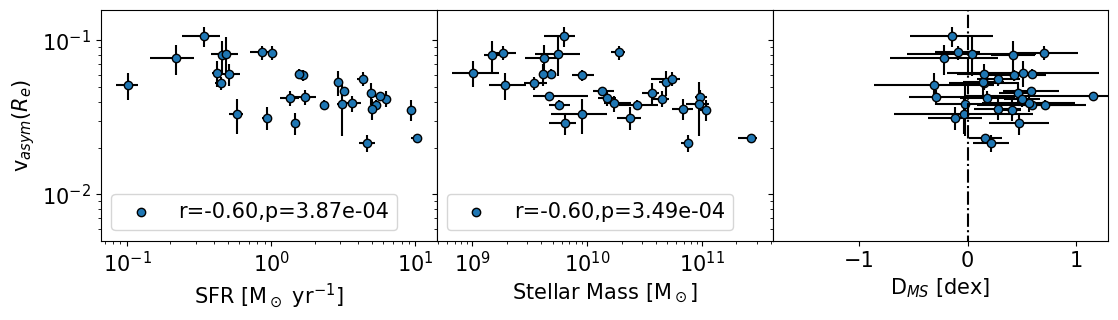

In [15]:
yerr = np.sqrt((mass_84_err/mass)**2 + (SFR_err/SFR)**2)
fig,(ax1,ax2,ax3) = plt.subplots(1,3,sharey="row",figsize=(13,3))
p=scipy.stats.pearsonr(np.log10(mass),np.log10(asym))
ax1.scatter(SFR,asym,ec="k",zorder=2,label=f"r={p[0]:.2f},p={p[1]:.2e}")
ax1.set_xlabel("SFR [M$_\odot$ yr$^{-1}$]")
ax1.errorbar(SFR,asym,xerr=SFR_err,yerr=asym_err,fmt=".k",zorder=1)
ax1.set_ylabel(r"v$_{asym} (R_e)$")
ax1.legend()
p=scipy.stats.pearsonr(np.log10(SFR),np.log10(asym))
ax2.scatter(mass,asym,ec="k",zorder=2,label=f"r={p[0]:.2f},p={p[1]:.2e}")
ax2.errorbar(mass,asym,xerr=[mass_16_err,mass_84_err],yerr=asym_err,fmt=".k",zorder=1)
ax2.set_xlabel("Stellar Mass [M$_\odot$]")
ax2.legend()
ax3.scatter(DMS,asym,zorder=2,ec="k")
ax3.errorbar(DMS,asym,xerr=yerr,yerr=asym_err,fmt=".k",zorder=1)
ax3.set_yscale("log")
ax3.vlines(0,ymin=10**(-2.5),ymax=10**(0.8),ls="dashdot",color="k")
ax3.set_xlim(-1.8,1.3)
ax3.set_xlabel(r"D$_{MS}$ [dex]")
for ax in [ax1,ax2]:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(10**(-2.3),10**(-0.8))
plt.subplots_adjust(wspace=0)
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/SM_SFR_asym.pdf",
            bbox_inches="tight")

In [16]:
s = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/"
                     "MAGPI_kinemetry_sample_1Re.csv")
galfit = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/"
                     "MAGPI_GalfitSersicCat_v0.1.csv")

galfit = galfit[galfit["MAGPIID"].isin(sample["MAGPIID"])]
prospect = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
prospect=prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]


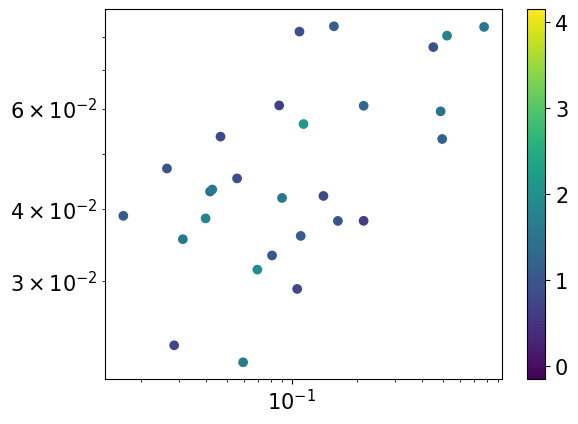

In [17]:
fig,ax= plt.subplots()
p=ax.scatter(sample['v_asym_s'],sample["v_asym_g"],c=galfit["n"],vmin=-0.15,vmax=4.15)
ax.set_xscale("log")
ax.set_yscale("log")
plt.colorbar(p,ax=ax)
plt.show()

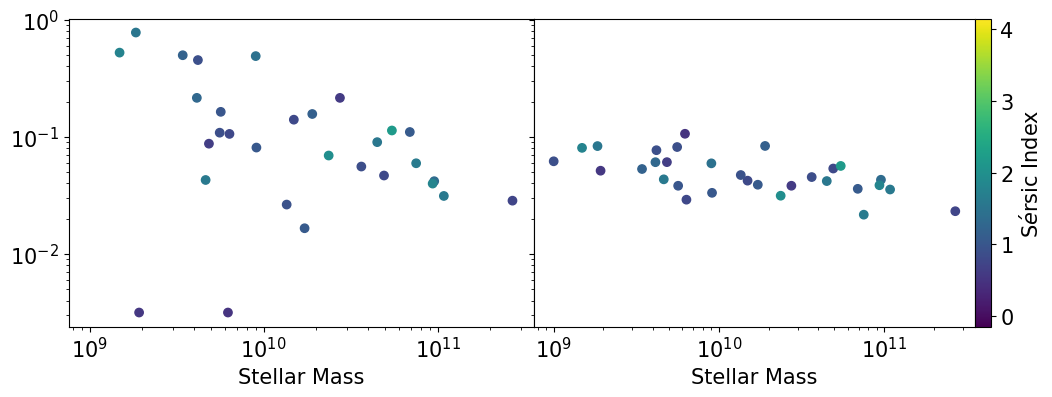

In [18]:
fig,(ax1,ax2)= plt.subplots(1,2,sharey="row",figsize=(12,4))
asym_g = sample["v_asym_g"].to_numpy()
asym_g[np.isnan(asym_g)]=10**(-2.5)
asym_s = sample["v_asym_s"].to_numpy()
asym_s[np.isnan(asym_s)]=10**(-2.5)
p=ax1.scatter(prospect["StellarMass_median"],asym_s,c=galfit["n"],vmin=-0.15,vmax=4.15)
p=ax2.scatter(prospect["StellarMass_median"],asym_g,c=galfit["n"],vmin=-0.15,vmax=4.15)
for ax in [ax1,ax2]:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel('Stellar Mass')
plt.colorbar(p,ax=ax,fraction=0.05,pad=0.00,label=r"S$\'{e}$rsic Index")
plt.subplots_adjust(wspace=0)
plt.show()

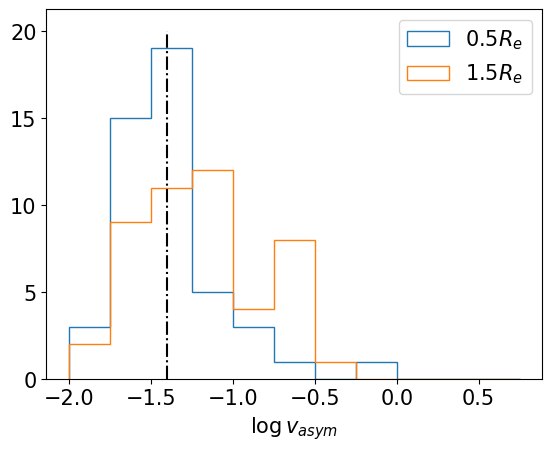

In [19]:
sample = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/kinemetry_sample_M2.csv")
sample = sample[sample["v_asym_15re_err"]<0.1]
re15 = np.log10(sample["v_asym_15re"].to_numpy())
re05 = np.log10(sample["v_asym_05re"].to_numpy())
plt.rcParams.update({"font.size":15})
fig,ax = plt.subplots()
ax.hist(re05,histtype="step",bins=np.arange(-2,1,0.25),label=r"$0.5R_e$")
ax.hist(re15,histtype="step",bins=np.arange(-2,1,0.25),label=r"$1.5R_e$")
ax.set_ylim(0,21.25)
ax.vlines(np.log10(0.04),ymin=0,ymax=20,ls="dashdot",color="k")
ax.legend()
ax.set_xlabel(r"$\log v_{asym}$")
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper1/asym_hist.pdf",
            bbox_inches="tight")

In [24]:
env = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/kinemetry_sample_env.csv")
env_sample = env[env["MAGPIID"].isin(sample["MAGPIID"])]
sample = sample[sample["MAGPIID"].isin(env_sample['MAGPIID'])]
asym = sample["v_asym_tot"].to_numpy()
asym_err = sample["v_asym_tot_err"].to_numpy()
master = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/"
                     "MAGPI_master_source_catalogue.csv",skiprows=16)
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
#master = master[master["MAGPIID"].isin(sample["MAGPIID"])]
d1_ = np.zeros(len(env_sample))
for i in range(len(env_sample)):
    group = env[env['GroupName'].isin([env_sample["GroupName"].to_numpy()[i]])]
    group_master = master[master["MAGPIID"].isin(group["MAGPIID"])]
    #print([env_sample['MAGPIID'].to_numpy()[i]])
    sample_master = master[master['MAGPIID'].isin([env_sample['MAGPIID'].to_numpy()[i]])]
    x = group_master["xmax"].to_numpy()
    y = group_master["ymax"].to_numpy()
    #print(x,y)
    x0 = sample_master["xmax"].to_numpy()[0]
    y0 = sample_master["ymax"].to_numpy()[0]
    z = sample_master["z"].to_numpy()[0]
    #print(x0,y0)
    d1 = np.sqrt((x-x0)**2 + (y-y0)**2)
    d1 = np.min(d1[d1>0])
    cd = cosmo.comoving_distance(z).to(u.kpc).value
    d1 = np.radians(d1*(0.2/3600))
    d1 = d1*cd
    d1_[i] = d1

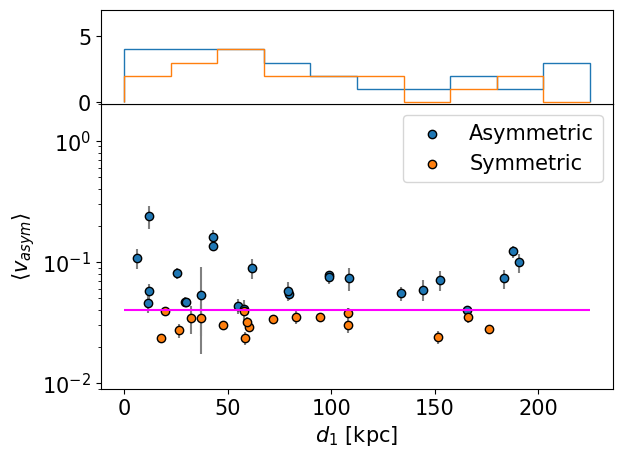

In [25]:
fig = plt.figure()
gs = fig.add_gridspec(2,1,height_ratios=(1,3),left=0.1,right=0.9,top=0.9,wspace=0,hspace=0)
ax=fig.add_subplot(gs[1,0])
ax.scatter(d1_[asym>0.04], asym[asym>0.04], ec="k",
           zorder=2,label="Asymmetric")
ax.errorbar(d1_[asym>0.04], asym[asym>0.04],
            yerr=asym_err[asym>0.04], ls="", color="grey", zorder=1)
ax.scatter(d1_[asym<0.04], asym[asym<0.04], ec="k",
           zorder=2,label="Symmetric")
ax.errorbar(d1_[asym<0.04], asym[asym<0.04],
            yerr=asym_err[asym<0.04], ls="", color="grey", zorder=1)
ax.hlines(0.04, xmin=0, xmax=225, color="fuchsia")
ax.set_yscale("log")
ax.set_ylim(9e-3, 2e0)
ax.set_xlabel("$d_1$ [kpc]")
ax.set_ylabel(r"$\langle v_{asym} \rangle$")
ax.legend()
ax_histy = fig.add_subplot(gs[0,0])
ax_histy.hist(d1_[asym>0.04],histtype="step",bins=np.arange(0,220,20))
ax_histy.hist(d1_[asym<0.04],histtype="step",bins=np.arange(0,220,20))
ax_histy.set_xticks([])
ax_histy.set_ylim(-0.15,7)
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper1/vasym_d1_hist.pdf",
            bbox_inches="tight")

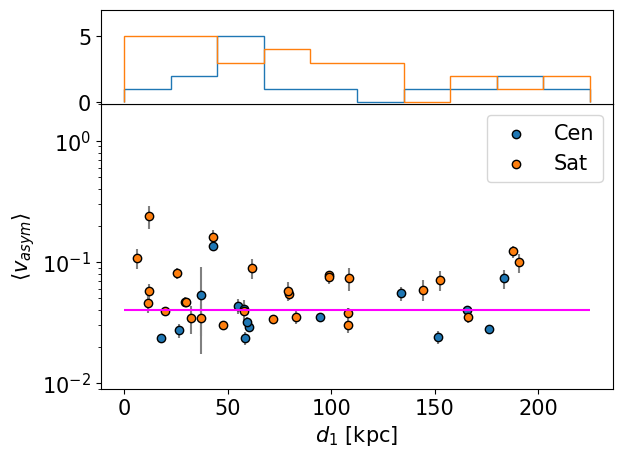

In [26]:
fig = plt.figure()
gs = fig.add_gridspec(2,1,height_ratios=(1,3),left=0.1,right=0.9,top=0.9,wspace=0,hspace=0)
ax=fig.add_subplot(gs[1,0])
ax.scatter(d1_[env_sample["BCG?"].to_numpy()], asym[env_sample["BCG?"].to_numpy()], ec="k",
           zorder=2,label="Cen")
ax.errorbar(d1_[env_sample["BCG?"].to_numpy()], asym[env_sample["BCG?"].to_numpy()],
            yerr=asym_err[env_sample["BCG?"].to_numpy()], ls="", color="grey", zorder=1)
ax.scatter(d1_[~env_sample["BCG?"].to_numpy()], asym[~env_sample["BCG?"].to_numpy()], ec="k",
           zorder=2,label="Sat")
ax.errorbar(d1_[~env_sample["BCG?"].to_numpy()], asym[~env_sample["BCG?"].to_numpy()],
            yerr=asym_err[~env_sample["BCG?"].to_numpy()], ls="", color="grey", zorder=1)
ax.hlines(0.04, xmin=0, xmax=225, color="fuchsia")
ax.set_yscale("log")
ax.set_ylim(9e-3, 2e0)
ax.set_xlabel("$d_1$ [kpc]")
ax.set_ylabel(r"$\langle v_{asym} \rangle$")
ax.legend()
ax_histy = fig.add_subplot(gs[0,0])
ax_histy.hist(d1_[env_sample["BCG?"].to_numpy()],histtype="step",bins=np.arange(0,220,20))
ax_histy.hist(d1_[~env_sample["BCG?"].to_numpy()],histtype="step",bins=np.arange(0,220,20))
ax_histy.set_xticks([])
ax_histy.set_ylim(-0.15,7)
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper1/vasym_d1_hist_cen.pdf",
            bbox_inches="tight")

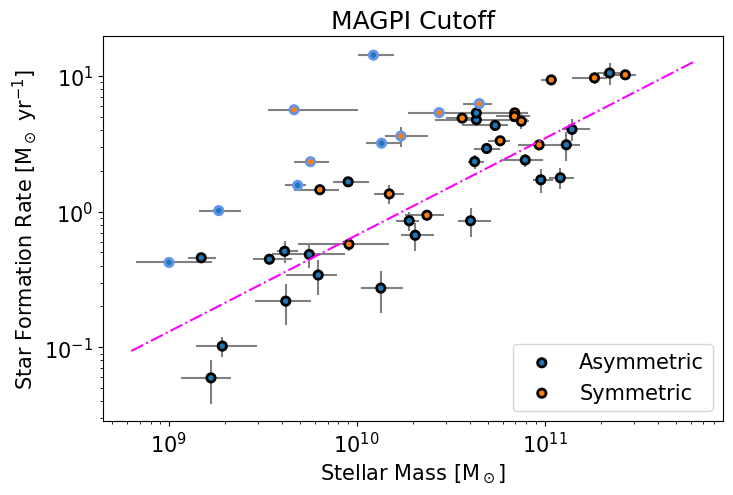

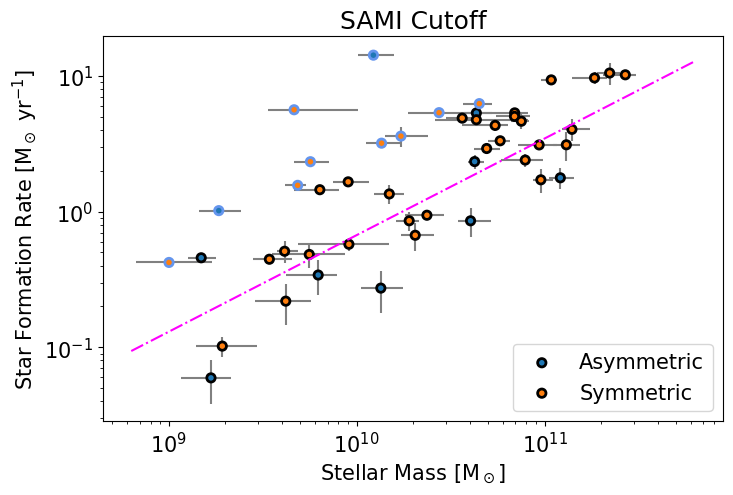

In [70]:
sample = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/kinemetry_sample_M2.csv")
sample = sample[sample["v_asym_15re_err"]<0.1]
asym = sample["v_asym_tot"].to_numpy()
prospect = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/"
                       "MAGPI_ProSpectCat_v0.1.csv")
bpt = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/"
                  "MAGPI_kinemetry_sample_BPT.csv")
prospect = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
bpt = bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
mass = prospect["StellarMass_median"].to_numpy()
mass_84_err = prospect["StellarMass_84"].to_numpy()
mass_84_err = mass_84_err - mass
mass_16_err = prospect["StellarMass_16"].to_numpy()
mass_16_err = mass - mass_16_err
SFR = bpt['SFR, dust corrected'].to_numpy()
SFR_err = bpt['SFR_err'].to_numpy()
xx = np.logspace(8.8,11.8,len(sample))
MS = (xx**0.712)*(10**-7.293)
colors = []
for i in range(len(SFR)):
    if np.log10(SFR[i]) - np.log10((mass[i]**0.712)*(10**-7.293)) > 0.5:
        colors.append("cornflowerblue")
    if 0.5 > np.log10(SFR[i]) - np.log10((mass[i]**0.712)*(10**-7.293)) > -1:
        colors.append("k")
    if np.log10(SFR[i]) - np.log10((mass[i]**0.712)*(10**-7.293)) < -1:
        colors.append("maroon")
colors=np.array(colors)

fig,ax = plt.subplots(figsize=(8,5))
ax.scatter(mass[asym>0.04],SFR[asym>0.04],zorder=2,ec=colors[asym>0.04],label="Asymmetric",lw=2)
ax.errorbar(mass[asym>0.04],SFR[asym>0.04],xerr=[mass_16_err[asym>0.04],mass_84_err[asym>0.04]],
            yerr=SFR_err[asym>0.04],ls="",color='grey',zorder=1)
ax.scatter(mass[asym<0.04],SFR[asym<0.04],zorder=2,ec=colors[asym<0.04],label="Symmetric",lw=2)
ax.errorbar(mass[asym<0.04],SFR[asym<0.04],xerr=[mass_16_err[asym<0.04],mass_84_err[asym<0.04]],
            yerr=SFR_err[asym<0.04],ls="",color='grey',zorder=1)
ax.plot(xx,MS,ls="dashdot",color="magenta")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title('MAGPI Cutoff')
ax.legend()
ax.set_xlabel(r"Stellar Mass [M$_\odot$]")
ax.set_ylabel(r"Star Formation Rate [M$_\odot$ yr$^{-1}$]")
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper1/SFMS_magpi.pdf",
            bbox_inches="tight")

odd = pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/kinemetry_sample_k24_k35.csv")
odd = odd[odd["MAGPIID"].isin(sample["MAGPIID"])]
asym = odd['k35_2re'].to_numpy()
fig,ax = plt.subplots(figsize=(8,5))
ax.scatter(mass[asym>0.068],SFR[asym>0.068],zorder=2,ec=colors[asym>0.068],label='Asymmetric',lw=2)
ax.errorbar(mass[asym>0.068],SFR[asym>0.068],xerr=[mass_16_err[asym>0.068],mass_84_err[asym>0.068]],
            yerr=SFR_err[asym>0.068],ls="",color='grey',zorder=1)
ax.scatter(mass[asym<0.068],SFR[asym<0.068],zorder=2,ec=colors[asym<0.068],label="Symmetric",lw=2)
ax.errorbar(mass[asym<0.068],SFR[asym<0.068],xerr=[mass_16_err[asym<0.068],mass_84_err[asym<0.068]],
            yerr=SFR_err[asym<0.068],ls="",color='grey',zorder=1)
ax.plot(xx,MS,ls="dashdot",color="magenta")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title('SAMI Cutoff')
ax.set_xlabel(r"Stellar Mass [M$_\odot$]")
ax.set_ylabel(r"Star Formation Rate [M$_\odot$ yr$^{-1}$]")
ax.legend()
plt.savefig("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/plots/paper1/SFMS_sami.pdf",
            bbox_inches="tight")

In [77]:
print(sample[sample['v_asym_05re_err']>0.1]['MAGPIID'])

27    1522132085
41    2301290261
Name: MAGPIID, dtype: int64


In [83]:
print(sample[sample['v_asym_05re_err']>0.1]["v_asym_15re_err"])
print(sample[sample['v_asym_05re_err']>0.1]["MAGPIID"])

27    0.037718
41    0.037049
Name: v_asym_15re_err, dtype: float64
27    1522132085
41    2301290261
Name: MAGPIID, dtype: int64


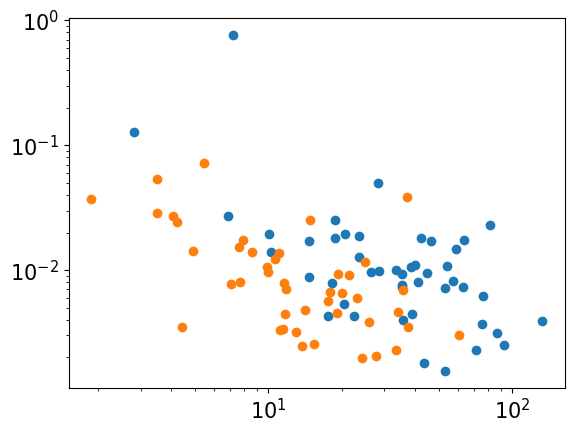

In [82]:
fig,ax = plt.subplots()
ax.scatter(sample['SNR_05re'],sample['v_asym_05re_err'],ec="k")
ax.scatter(sample['SNR_15re'],sample['v_asym_15re_err'],ec="k")
ax.set_xscale("log")
ax.set_yscale("log")